In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

THETA = 3 # in degrees
MASS = 6e3 # in kg
DT = 0.001 # in seconds

def thrust(alpha,theta=np.deg2rad(THETA),T=(1e6 + MASS*1*9.8)/np.cos(np.deg2rad(THETA)),mass=MASS):
    """ 
    calculates thrust in inertial (parent) direction
    inputs:
    - alpha in rad
    - theta in rad
    - T in N (absolute value of net thrust)

    output:
    - 2D vector

    Notes: 
    Mg force is added in this just cz it was acting on CG itself, and I didnt't wanna make many changes
    """

    # have added this because we were not able to change the direction of all motor, it was feasible only for 2
    # so have modified the net thrust based on theta 


    T_hb = (2*267*np.cos(theta) + 2*267 + 2*20)*1e3
    T_vb = (2*267*np.sin(theta))
    T = np.sqrt(T_hb**2+T_vb**2)


    # the return statement of this function includes mg term also  
    # hence it outputs thrust + mg in vector for in parent's frame  
    return np.array([T*np.cos(-alpha+theta)-mass*9.8/np.sqrt(2),-T*np.sin(-alpha+theta)-mass*9.8/np.sqrt(2)])



def drag(alpha,beta,D = 1e6):
    """
    calculates drag in inertial (parent) direction
    inputs:
    - alpha in rad
    - beta in rad
    - D in N (absolute value of net thrust)

    output: 
    - 2D vector
    """
    return np.array([-D*np.cos(beta-alpha),D*np.sin(beta-alpha)])

def R_i2b(alpha,vec):
    """ 
    returns rotated vector in the body frame (x,y) from the interial {parent (X,Y)}
    alpha in rad
    """
    rotMat = np.array( [ [ np.cos(alpha), np.sin(alpha) ], [ -np.sin(alpha), np.cos(alpha)] ] )   
    return np.matmul(rotMat,vec)

def moment(alpha, drag, l = 0.5):
    """ 
    calculates positive value standard right hand rule i.e. outside plane moment is positive
    l is distance between cg and cp
    distance between cg and ct is assumed 0 {ct is the point at which thrust acts}
    """
    dragRot = -R_i2b(alpha,drag)
    return dragRot[1]*l

def moi(m=6000,r=2.5,l=10):
    """
    moment of intertia, will be used in future for variable mass and exact CG location
    """
    return m*(0.25*r**2 + (1/12)*l**2)+m*(1.5)**2


def betaFromV(alpha, v):
    """
    input:
    - alpha in radians
    - velocity vector in inertial frame
    output:
    - in radians
    """
    vRot = R_i2b(alpha,v) # transform velcity vector from parent to pod frame
    return np.arctan(-vRot[1]/vRot[0])

def updateV(vo, T, D, dt = DT, m = MASS):
    """
    newton's law
    """
    # return vo + ((T+D)/m+np.array([0,-9.8]))*dt # for absolute displacement in Y (but first have to rotate everything in real inertial frame)
    return vo + ((T+D)/m)*dt

def updateAlphadot(alphaDot, moment, moi, dt = DT):
    """
    we know that doube derivative of alpha wrt time is net_Torque/Moment of inertia
    input:
    - rad/sec
    - N-m
    - kg-m^2
    """
    return alphaDot + (moment/moi)*dt

def updateAlpha(alphao, alphaDot, dt = DT):
    """ 
    took modulus for plots
    """
    # return (alphao + alphaDot*dt)%(2*np.pi)
    return (alphao + alphaDot*dt)

def getAngle(vec):
    return np.arctan(vec[1]/vec[0])

def legendArr(thetaArr,cg_cp_Arr):
    a = []
    for i in thetaArr:
        for j in cg_cp_Arr:
            a.append("theta = " + str(i) + " CG-CP = " + str(j))
    return a
def s(V):
    s_x = V[:,0]* DT
    s_y = V[:,1]* DT
    s_x = s_x.cumsum()
    s_y = s_y.cumsum()
    return s_x,s_y

In [2]:
def loopAll(cg_cp = 0.5, theta = 6.4,loopTime = 5):
    MASS = 6e3
    #declaring empty arrays
    t = np.arange(0,loopTime+ DT, DT) 
    alph = np.zeros(len(t))
    bet = np.zeros(len(t))
    T = np.zeros((len(t),2))
    D = np.zeros((len(t),2))
    V = np.zeros((len(t),2))
    alphDot = np.zeros(len(t))
    tau = np.zeros(len(t)) 

    # initializing t = 0 values
    T[0] =  thrust(alph[0],np.deg2rad(theta),(1e6 + MASS*1*9.8)/np.cos(np.deg2rad(theta)))
    D[0] =  drag(alph[0],bet[0])
    V[0] = np.array([600,0])
    I =  moi()
    for i in range(1,len(t)):
        V[i] =  updateV(V[i-1],T[i-1],D[i-1])
        bet[i] =  betaFromV(alph[i-1],V[i])
        tau[i] =  moment(alph[i-1],D[i-1],cg_cp)
        alphDot[i] =  updateAlphadot(alphDot[i-1],tau[i],I)
        alph[i] =  updateAlpha(alph[i-1],alphDot[i-1])
        T[i] =  thrust(alph[i],np.deg2rad(theta),(1e6 + MASS*1*9.8)/np.cos(np.deg2rad(theta)))
        D[i] =  drag(alph[i],bet[i])
    return alph,bet,V

In [3]:
thetaArr = np.arange(0,16,1)


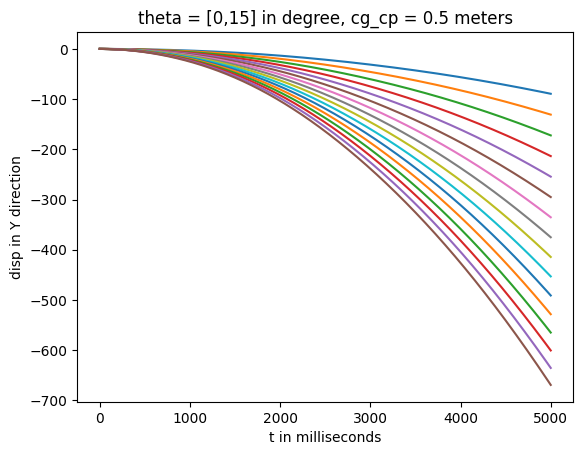

In [5]:
for i in range(0,len(thetaArr)):
    alph,bet,V = loopAll( 0.5,thetaArr[i])
    disp = s(V)
    plt.plot(disp[1])
legend = legendArr(thetaArr,[ 0.5])
# plt.legend(legend,loc = 'center right', bbox_to_anchor=(1.4,0.5))
plt.title("theta = [0,15] in degree, cg_cp = "+str( 0.5)+" meters")
plt.xlabel("t in milliseconds")
plt.ylabel("disp in Y direction")
plt.show()

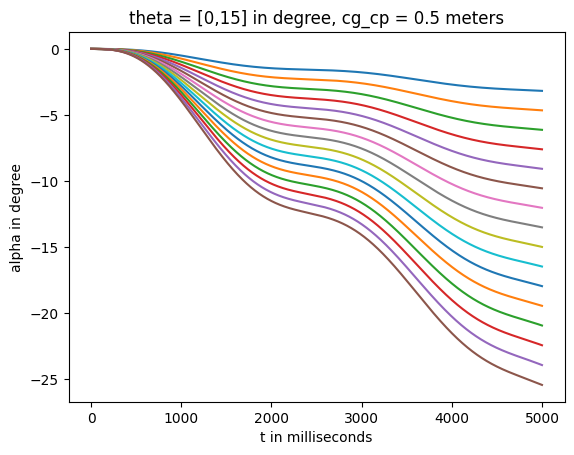

In [6]:
for i in range(0,len(thetaArr)):
    alph,bet,V = loopAll( 0.5,thetaArr[i])
    plt.plot(np.rad2deg(alph))
legend = legendArr(thetaArr,[ 0.5])
# plt.legend(legend,loc = 'center right', bbox_to_anchor=(1.4,0.5))
plt.title("theta = [0,15] in degree, cg_cp = "+str( 0.5)+" meters")
plt.xlabel("t in milliseconds")
plt.ylabel("alpha in degree")
plt.show()

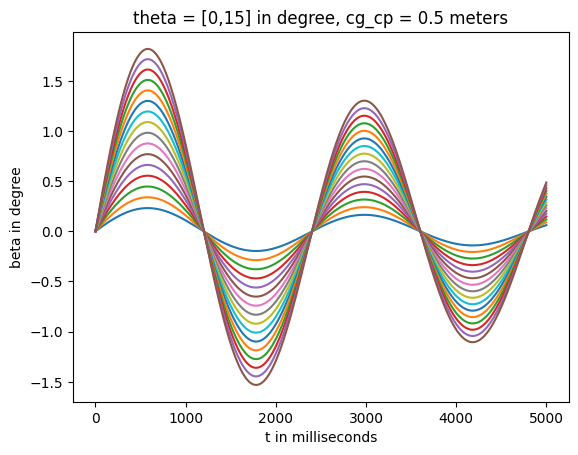

In [7]:
for i in range(0,len(thetaArr)):
    alph,bet,V = loopAll( 0.5,thetaArr[i])
    plt.plot(np.rad2deg(bet))
legend = legendArr(thetaArr,[ 0.5])
# plt.legend(legend,loc = 'center right', bbox_to_anchor=(1.4,0.5))
plt.title("theta = [0,15] in degree, cg_cp = "+str( 0.5)+" meters")
plt.xlabel("t in milliseconds")
plt.ylabel("beta in degree")
plt.show()

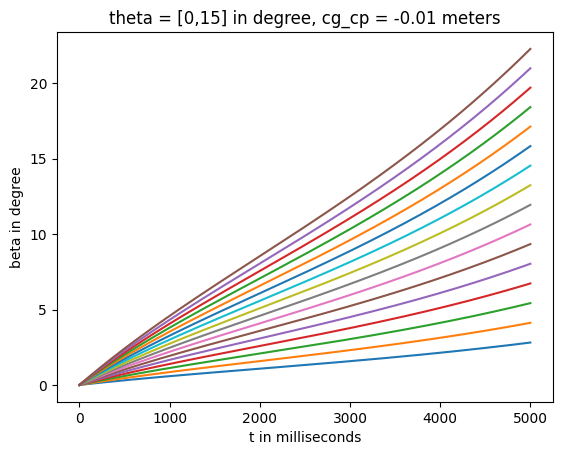

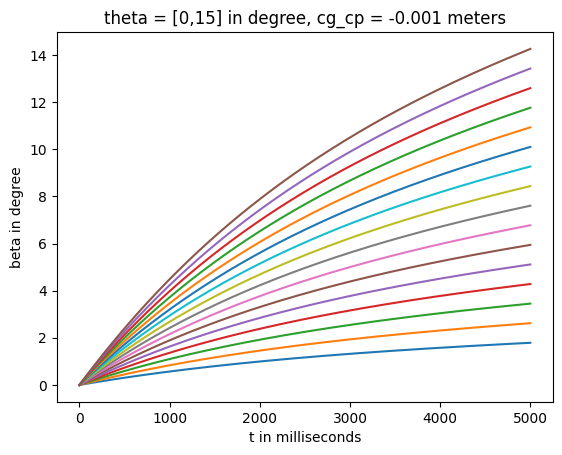

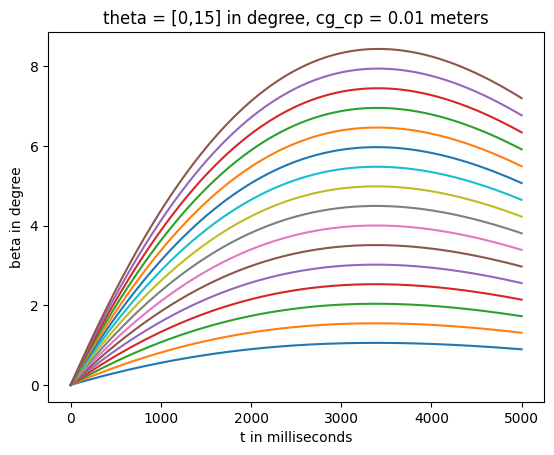

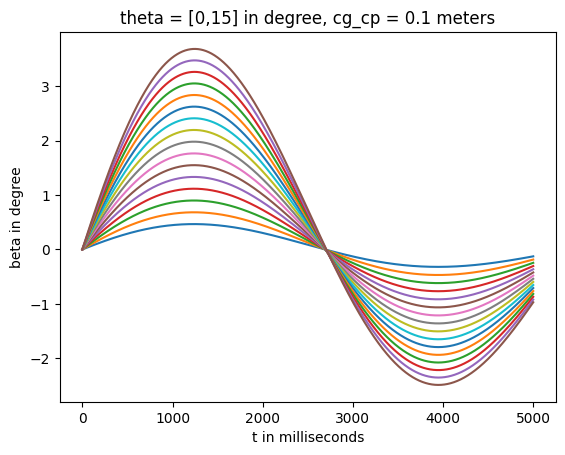

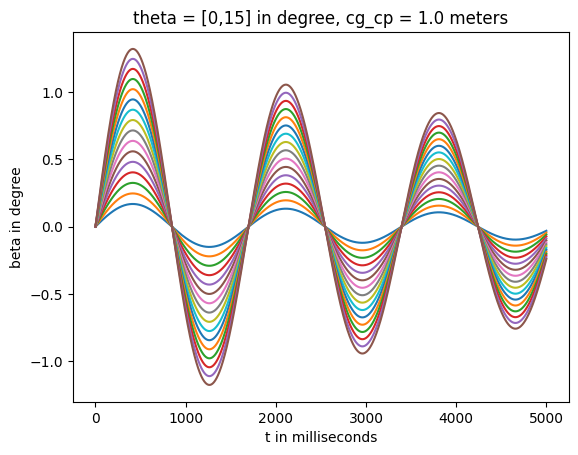

In [8]:
cg_cp_Arr = np.array([-0.01,-0.001,0.01,0.1,1])
for j in range(0,len(cg_cp_Arr)):
    for i in range(0,len(thetaArr)):
        alph,bet,V = loopAll(cg_cp_Arr[j],thetaArr[i])
        plt.plot(np.rad2deg(bet))
    legend = legendArr(thetaArr,[cg_cp_Arr[j]])
    # plt.legend(legend,loc = 'center right', bbox_to_anchor=(1.4,0.5))
    plt.title("theta = [0,15] in degree, cg_cp = "+str(cg_cp_Arr[j])+" meters")
    plt.xlabel("t in milliseconds")
    plt.ylabel("beta in degree")
    plt.show()